the session will be uploaded from the fetch_data file in scripts/

I'm starting my analysis beginning from the quali as it is important for the rest of the race, the goal of this is to rank all drivers on an descending order from pole position, and visuallt plot to show the difference in time it took for them to finish quali

In [129]:
import sys
sys.path.append('../scripts')   # allows pysthon to find scripts/ folder

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from timple.timedelta import strftimedelta

import fastf1
import fastf1.plotting
from fastf1.core import Laps

# Enable Matplotlib patches for plotting timedelta values
fastf1.plotting.setup_mpl(mpl_timedelta_support=True, color_scheme=None)

from fetch_data import load_session

session  = load_session(2025, "Monza", "Q")

core           INFO 	Loading data for Italian Grand Prix - Qualifying [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '4', '81', '16', '44', '63', '12', '5', '14', '22', '87', '27', '55', '23', '31', '6', '18', '43', '10', '30']


On this cell I selceted all the drivers from session.laps and got only their first occurence using pd.unique

In [130]:
drivers = pd.unique(session.laps['Driver'])
print(drivers)

list_fastest_laps = list()

# loop to get each drivers fastest lap and append them to the list
for drv in drivers:
    current_drivers_fastest_lap = session.laps.pick_drivers(drv).pick_fastest()
    list_fastest_laps.append(current_drivers_fastest_lap)
    
    # reconstruct the list into a data frame and sort the values in descending order by laptime, dropping the oringinal indexes
fastest_laps = Laps(list_fastest_laps) \
    .sort_values(by='LapTime') \
    .reset_index(drop=True)

['VER' 'NOR' 'PIA' 'LEC' 'HAM' 'RUS' 'ANT' 'BOR' 'ALO' 'TSU' 'BEA' 'HUL'
 'SAI' 'ALB' 'OCO' 'HAD' 'STR' 'COL' 'GAS' 'LAW']


Getting the fastest driver on the list and calculating each other drivers delta time as the difference from the first position

In [131]:
pole_lap = fastest_laps.pick_fastest() # returns the fastest driver
fastest_laps['LapTimeDelta'] = fastest_laps['LapTime'] - pole_lap['LapTime'] #calculates each drivers delta based on the fastest driver +..

print(fastest_laps[['Driver', 'LapTime', 'LapTimeDelta']])

   Driver                LapTime           LapTimeDelta
0     VER 0 days 00:01:18.792000        0 days 00:00:00
1     NOR 0 days 00:01:18.869000 0 days 00:00:00.077000
2     PIA 0 days 00:01:18.982000 0 days 00:00:00.190000
3     LEC 0 days 00:01:19.007000 0 days 00:00:00.215000
4     HAM 0 days 00:01:19.124000 0 days 00:00:00.332000
5     RUS 0 days 00:01:19.157000 0 days 00:00:00.365000
6     ANT 0 days 00:01:19.200000 0 days 00:00:00.408000
7     BOR 0 days 00:01:19.323000 0 days 00:00:00.531000
8     ALO 0 days 00:01:19.362000 0 days 00:00:00.570000
9     TSU 0 days 00:01:19.433000 0 days 00:00:00.641000
10    BEA 0 days 00:01:19.446000 0 days 00:00:00.654000
11    HUL 0 days 00:01:19.498000 0 days 00:00:00.706000
12    SAI 0 days 00:01:19.528000 0 days 00:00:00.736000
13    ALB 0 days 00:01:19.583000 0 days 00:00:00.791000
14    OCO 0 days 00:01:19.707000 0 days 00:00:00.915000
15    HAD 0 days 00:01:19.917000 0 days 00:00:01.125000
16    STR 0 days 00:01:19.948000 0 days 00:00:01

Add all the team colors in a list and plot the data to showcase the difference each driver had from the first place

In [132]:
#Just creates a list of team colors for the e plot
team_colors = list()
for index, lap in fastest_laps.iterlaps():
    color = fastf1.plotting.get_team_color(lap['Team'], session=session)
    team_colors.append(color)

Visually showing the difference in time between different drivers in quali

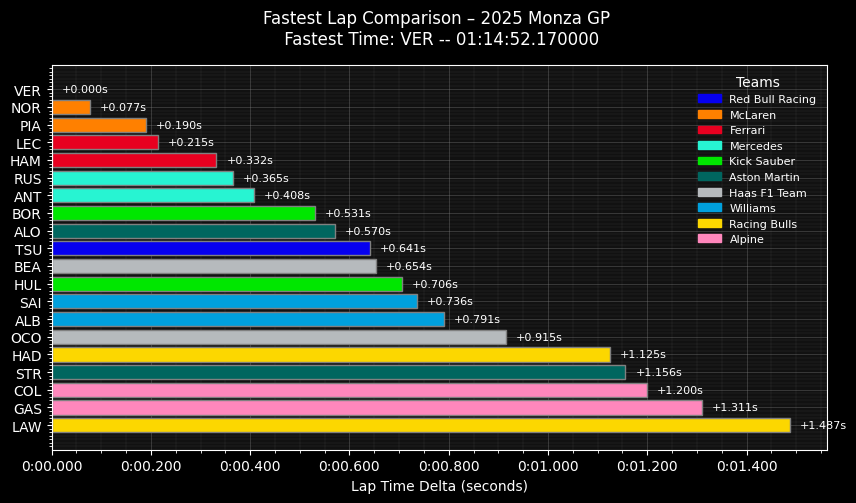

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), facecolor='black')
ax.set_facecolor('#111111')

ax.barh(fastest_laps.index, fastest_laps['LapTimeDelta'],
        color=team_colors, edgecolor='grey')
ax.set_yticks(fastest_laps.index)
ax.set_yticklabels(fastest_laps['Driver'])

ax.set_title(f"Fastest Quali Lap Comparison – 2025 Monza GP \n Fastest Time: {pole_lap.Driver} -- {str(pole_lap['Time']).split()[-1]}", 
             color='white', 
             pad=15)
ax.set_xlabel("Lap Time Delta (seconds)", color='white')

# To add seconds on the side of each drivers time for more readibility
for i, delta in enumerate(fastest_laps['LapTimeDelta']):
    ax.text(delta + pd.Timedelta(seconds=0.02), #offsets the label so they dotn overlap
            i,
            f"+{delta.total_seconds():.3f}s",
            va='center',
            color='white',
            fontsize=8)

# iverts to show fastest at the top
ax.invert_yaxis()

# draw vertical lines behind the bars
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
ax.grid(which='minor', color='gray', linestyle='-', linewidth=0.3, alpha=0.3)

# draw the lines in between major lines
ax.minorticks_on()

# Keep grid behind bars
ax.set_axisbelow(True)

# Create one legend entry per team
unique_teams = fastest_laps['Team'].unique()
legend_patches = []

for team in unique_teams:
    color = fastf1.plotting.get_team_color(team,session=session)
    patch = mpatches.Patch(color=color, label=team)
    legend_patches.append(patch)

# Add legend to plot
ax.legend(handles=legend_patches,
          loc='upper right',
          frameon=False,
          labelcolor='white',
          title='Teams',
          title_fontsize=10,
          fontsize=8)

What can we get from this?

    - Verstappen has the fastest time (also shown at the top of the graphic)
    - Every other drivers time is shown relative to verstappens, with the difference in seconds for accuracy on the side of the bar
    - Easily distinct teams by color (for example ferrari drivers are shown with 'red') also contains the legend for reference
    